In [3]:
from ipywidgets import interact
from matplotlib import pyplot as plt
import time
from numpy import random
random.seed(0)

In [4]:
from sequence.kernel.timeline import Timeline
from sequence.topology.node import QuantumRouter, MiddleNode
from sequence.components.optical_channel import QuantumChannel, ClassicalChannel

In [5]:
def test(sim_time, cc_delay, qc_atten, qc_dist):
    """
    sim_time: duration of simulation time (ms)
    cc_delay: delay on classical channels (ns)
    qc_atten: attenuation on quantum channels (db/m)
    qc_dist: distance of quantum channels (km)
    """
    cc_delay *= 1e6
    qc_dist *= 1e3
    raw_fidelity = 0.85
    tl = Timeline(sim_time * 1e9)
    
    # create our quantum nodes and update parameters as needed
    r1 = QuantumRouter("r1", tl, 50)
    r2 = QuantumRouter("r2", tl, 100)
    r3 = QuantumRouter("r3", tl, 50)
    m1 = MiddleNode("m1", tl, ["r1", "r2"])
    m2 = MiddleNode("m2", tl, ["r2", "r3"])
    for node in [r1, r2, r3]:
        node.memory_array.update_memory_params("coherence_time", 10)
    for node in [r1,r2,r3]:
        node.memory_array.update_memory_params("raw_fidelity", raw_fidelity)
    
    # create all-to-all classical connections
    for node1 in [r1,r2,r3,m1,m2]:
        for node2 in [r1,r2,r3,m1,m2]:
            cc = ClassicalChannel("cc_%s_%s"%(node1.name, node2.name), tl, 1e3, delay=cc_delay)
            cc.set_ends(node1, node2)

    # create routing table manually
    # note that the routing table is based on quantum links, not classical
    r1.network_manager.protocol_stack[0].add_forwarding_rule("r2", "r2")
    r1.network_manager.protocol_stack[0].add_forwarding_rule("r3", "r2")
    r2.network_manager.protocol_stack[0].add_forwarding_rule("r1", "r1")
    r2.network_manager.protocol_stack[0].add_forwarding_rule("r3", "r3")
    r3.network_manager.protocol_stack[0].add_forwarding_rule("r1", "r2")
    r3.network_manager.protocol_stack[0].add_forwarding_rule("r2", "r2")
    
    # create quantum channels linking r1 and r2 to m2
    qc1 = QuantumChannel("qc_r1_m1", tl, qc_atten, qc_dist)
    qc1.set_ends(r1, m1)
    qc2 = QuantumChannel("qc_r2_m1", tl, qc_atten, qc_dist)
    qc2.set_ends(r2, m1)
    # create quantum channels linking r2 and r3 to m2
    qc3 = QuantumChannel("qc_r2_m2", tl, qc_atten, qc_dist)
    qc3.set_ends(r2, m2)
    qc4 = QuantumChannel("qc_r3_m2", tl, qc_atten, qc_dist)
    qc4.set_ends(r3, m2)
    
    # run our simulation
    tl.init()
    r1.network_manager.request("r3", 1e12, 1e14, 50, 0.9)

    tick = time.time()
    tl.run()
    print("execution time %.2f sec" % (time.time() - tick))
    
    # display collected metric for number of entangled memories on r1
    data = []
    for info in r1.resource_manager.memory_manager:
        if info.entangle_time > 0:
            data.append(info.entangle_time / 1e12)
    data.sort()
    plt.plot(data, range(1, len(data) + 1), marker="o")
    plt.suptitle("Entangled Memories on r1")
    plt.xlabel("Simulation Time (s)")
    plt.ylabel("Aggregated Number of Entangled Memory")
    plt.show()
    
    # display collected metric for number of entangled memories on r2
    data = []
    for info in r2.resource_manager.memory_manager:
        if info.entangle_time > 0:
            data.append(info.entangle_time / 1e12)
    data.sort()
    plt.plot(data, range(1, len(data) + 1), marker="o")
    plt.suptitle("Entangled Memories on r2")
    plt.xlabel("Simulation Time (s)")
    plt.ylabel("Aggregate Number of Entangled Memories r2")
    plt.show()
    
    # display collected metric for number of entangled memories on r3
    data = []
    for info in r3.resource_manager.memory_manager:
        if info.entangle_time > 0:
            data.append(info.entangle_time / 1e12)
    data.sort()
    plt.plot(data, range(1, len(data) + 1), marker="o")
    plt.suptitle("Entangled Memories on r3")
    plt.xlabel("Simulation Time (s)")
    plt.ylabel("Aggregate Number of Entangled Memories")
    plt.show()

    # display collected metric for memory fidelities on r1
    data = []
    for info in r1.resource_manager.memory_manager:
        data.append(info.fidelity)
    plt.bar(range(len(data)), data)
    plt.plot([0, len(data)], [raw_fidelity, raw_fidelity], "k--")
    plt.plot([0, len(data)], [0.9, 0.9], "k--")
    plt.ylim(0.7,1)
    plt.suptitle("Memory Fidelities on r1")
    plt.xlabel("Memory")
    plt.ylabel("Fidelity")
    plt.show()

    # display collected metric for memory fidelities on r2
    data = []
    for info in r2.resource_manager.memory_manager:
        data.append(info.fidelity)
    plt.bar(range(len(data)), data)
    plt.plot([0, len(data)], [raw_fidelity, raw_fidelity], "k--")
    plt.plot([0, len(data)], [0.9, 0.9], "k--")
    plt.ylim(0.7,1)
    plt.suptitle("Memory Fidelities on r2")
    plt.xlabel("Memory")
    plt.ylabel("Fidelity")
    plt.show()

    # display collected metric for memory fidelities on r3
    data = []
    for info in r3.resource_manager.memory_manager:
        data.append(info.fidelity)
    plt.bar(range(len(data)), data)
    plt.plot([0, len(data)], [raw_fidelity, raw_fidelity], "k--")
    plt.plot([0, len(data)], [0.9, 0.9], "k--")
    plt.ylim(0.7,1)
    plt.suptitle("Memory Fidelities on r3")
    plt.xlabel("Memory")
    plt.ylabel("Fidelity")
    plt.show()

execution time 18.79 sec


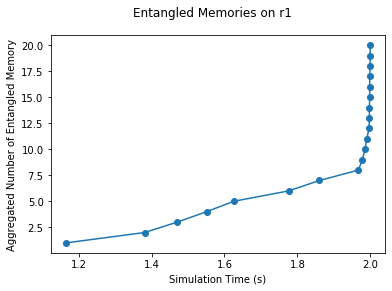

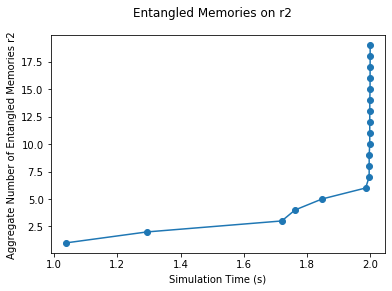

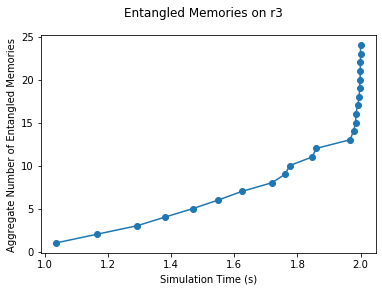

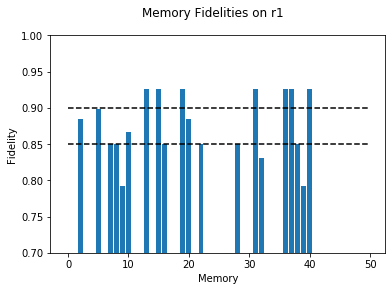

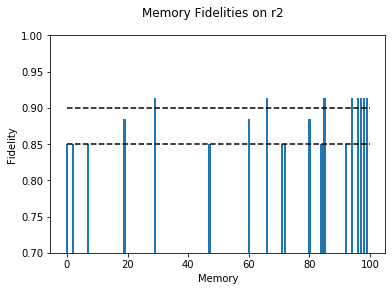

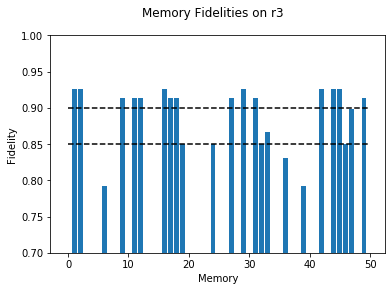

In [8]:
test(2000, 1000, 0.0002, 5)